# Dataset Retrieval

In [ ]:
!pip install kaggle

import os

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = "shanerana"
os.environ['KAGGLE_KEY'] = "2f6efa9207fa4697c039e00323ac0a69"

# Download the dataset
!kaggle datasets download -d denizkavi1/brain-tumor

100% 698M/700M [00:06<00:00, 169MB/s]
100% 700M/700M [00:06<00:00, 108MB/s]


In [ ]:
!unzip -q -o brain-tumor.zip -d /content/extracted_data/

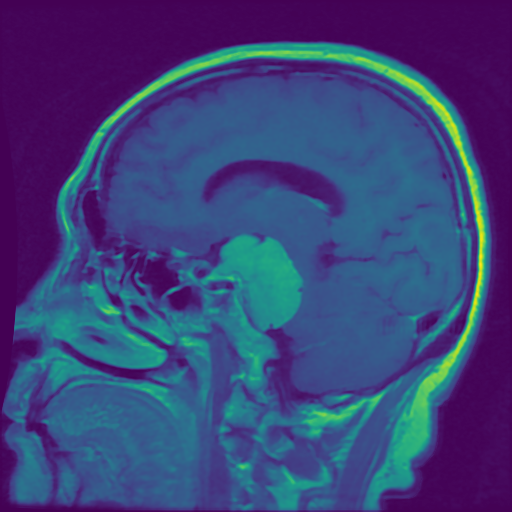

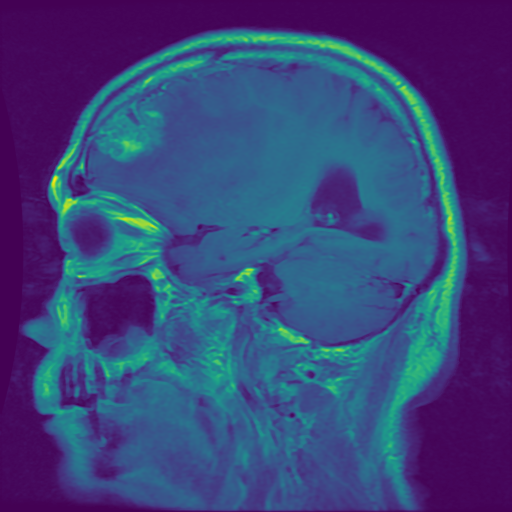

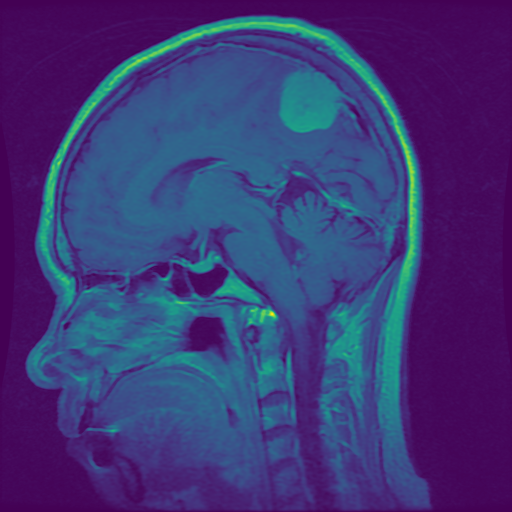

In [ ]:
import os
import zipfile
from PIL import Image
import IPython.display as display

# Define the path to the directory containing the images
images_directory = '/content/extracted_data/1'

# Display the first few images
num_images_to_display = 3
image_files = [os.path.join(images_directory, file) for file in os.listdir(images_directory)[:num_images_to_display] if file.endswith('.png')]
for i in range(len(image_files)):
    img = Image.open(image_files[i])
    display.display(img)

# Data Augmentation and Preprocessing

In [ ]:
import torch

from torch import Generator
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms

import cv2
import numpy as np

# Set random seed
torch.manual_seed(1)

In [ ]:
class AddGaussianNoise(object):
    # This class defines a function which has a random probability (p) to add noise to an image
    def __init__(self, mean=0, std=1, p=0.1):
        self.std = std
        self.mean = mean
        self.p = p

    def __call__(self, image):
        if self.p < torch.rand(1):
            return image
        else:
            x = torch.randn(image.size()[1:])*(torch.randn(image.size()[1:])<0.8) * self.std + self.mean
            image += x
            image[image<=0] = 0
            return image

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p}, mean={self.mean}, std={self.std})'

class StretchImage(object):
    # This class defines a function which has a random probability (p) to stretch an image
    def __init__(self, max_factor=1, p=0.1):
        self.max_factor = max_factor
        self.p = p

    def __call__(self, image):
        if self.p < torch.rand(1):
            return image
        else:
            width, height = image.size()[1:]
            new_width = int(width * self.max_factor)
            stretched_image = transforms.Resize((height, new_width))(image)
            out_image = transforms.CenterCrop((height, width))(stretched_image)
            return out_image

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p}, max_factor={self.max_factor})'

class BilateralFilter(object):
    # This class defines a function which applies a bilateral filter to an image, reducing noise
    def __init__(self):
        pass

    def __call__(self, image):
        image = image.numpy().transpose(1, 2, 0)
        image = cv2.bilateralFilter(image,3, 1, 1)
        image = image.transpose(2, 0, 1)
        return torch.from_numpy(image)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
class TransformDataset(Dataset):
    # This class can be used to apply transformations to a dataset
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transforms:
            x = self.transforms(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
# Get dataset from folder
dataset = ImageFolder(
    root = '/content/extracted_data',
)

# Split the dataset into train and test sets
dataset_size = len(dataset)
lengths = list(map(lambda x: int(x * dataset_size), [0.8, 0.2]))
lengths[-1] += dataset_size - sum(lengths)
train, test = random_split(
        dataset,
        lengths,
        Generator().manual_seed(42))

# Apply data preprocessing and augmentation to train set
train_data = TransformDataset(train, transforms=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #AUGMENTATION
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(10)]),p=0.1),
        AddGaussianNoise(mean=0, std=0.01, p=0.1),
        StretchImage(max_factor=1.2,p=0.1),
        #PREPROCESSING
        BilateralFilter()
]))
train_loader = DataLoader(train_data, batch_size=64,generator=Generator().manual_seed(42))

# Apply data preprocessing to test set
test_data = TransformDataset(test, transforms=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #PREPROCESSING
        BilateralFilter()
]))
test_loader = DataLoader(test_data, batch_size=64,generator=Generator().manual_seed(42))

train_size = len(train_loader)
test_size = len(test_loader)


# Exploration data
exploration_1_data = TransformDataset(test, transforms=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #Adding Noise
        AddGaussianNoise(mean=0, std=0.02, p=1),
        #PREPROCESSING
        BilateralFilter()
]))
exploration_1_loader = DataLoader(exploration_1_data, batch_size=64,generator=Generator().manual_seed(42))

exploration_2_data = TransformDataset(test, transforms=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #Stretching
        StretchImage(max_factor=1.2,p=1),
        #PREPROCESSING
        BilateralFilter()
]))
exploration_2_loader = DataLoader(exploration_2_data, batch_size=64,generator=Generator().manual_seed(42))

exploration_3_data = TransformDataset(test, transforms=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #Adding Noise and stretching
        AddGaussianNoise(mean=0, std=0.02, p=1),
        StretchImage(max_factor=1.2,p=1),
        #PREPROCESSING
        BilateralFilter()
]))
exploration_3_loader = DataLoader(exploration_3_data, batch_size=64,generator=Generator().manual_seed(42))

# Model Initialisation

In [ ]:
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision.models import resnet50, vgg16, googlenet, alexnet

# Allow PyTorch to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models with default random initial weights
resnet50_base = resnet50(num_classes=3).to(device)

vgg16_base = vgg16(num_classes=3).to(device)

googlenet_base = googlenet(num_classes=3,aux_logits=False).to(device)

alexnet_base = alexnet(num_classes=3).to(device)

# Create models with pretrained weights
resnet50_pretrained = resnet50(weights = 'IMAGENET1K_V1')
resnet50_pretrained.fc = nn.Linear(in_features=2048, out_features=3) # This replaces the final layer of the model, so it has 3 output nodes instead of 1000
resnet50_pretrained.to(device)

vgg16_pretrained = vgg16(weights = 'IMAGENET1K_V1')
vgg16_pretrained.classifier[6] = nn.Linear(in_features=4096, out_features=3)
vgg16_pretrained.to(device)

googlenet_pretrained = googlenet(weights = 'IMAGENET1K_V1')
googlenet_pretrained.fc = nn.Linear(in_features=1024, out_features=3)
googlenet_pretrained.to(device)

alexnet_pretrained = alexnet(weights = 'IMAGENET1K_V1')
alexnet_pretrained.classifier[6] = nn.Linear(in_features=4096, out_features=3)
alexnet_pretrained.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 107MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpo

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Model Training

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/IPPR

/content/drive/MyDrive/IPPR


In [ ]:
path = os.getcwd()
weights_path = os.path.join(path, 'ModelWeights')
if not os.path.exists(weights_path):
  os.mkdir(weights_path)

In [ ]:
def train_model(net, train_loader, LR, name, epochs = 1, verbose = False):
    # This functions trains a model according to the given parameters
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        net.parameters(),
        lr=LR
    )
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
            else:
                inputs, labels = Variable(inputs).cpu(), Variable(labels).cpu()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
        if verbose:
            print(f'model: {name} \tepoch: {epoch} \tloss:{sum_loss/train_size:.2f}')
        sum_loss = 0.0
    torch.save(net,f"{weights_path}/{name}_weights.pt")

In [ ]:
# Training each model
train_model(resnet50_base, train_loader, 0.001, "resnet50_base", epochs = 10, verbose = True)
train_model(vgg16_base, train_loader, 0.001, "vgg16_base", epochs = 10, verbose = True)
train_model(googlenet_base, train_loader, 0.001, "googlenet_base", epochs = 10, verbose = True)
train_model(alexnet_base, train_loader, 0.001, "alexnet_base", epochs = 10, verbose = True)
train_model(resnet50_pretrained, train_loader, 0.001, "resnet50_pretrained", epochs = 10, verbose = True)
train_model(vgg16_pretrained, train_loader, 0.001, "vgg16_pretrained", epochs = 10, verbose = True)
train_model(googlenet_pretrained, train_loader, 0.001, "googlenet_pretrained", epochs = 10, verbose = True)
train_model(alexnet_pretrained, train_loader, 0.001, "alexnet_pretrained", epochs = 10, verbose = True)

In [ ]:
# Loading each trained model from a file
resnet50_base = torch.load(f"{weights_path}/resnet50_base_weights.pt", map_location=device)
vgg16_base = torch.load(f"{weights_path}/vgg16_base_weights.pt", map_location=device)
googlenet_base = torch.load(f"{weights_path}/googlenet_base_weights.pt", map_location=device)
alexnet_base = torch.load(f"{weights_path}/alexnet_base_weights.pt", map_location=device)
resnet50_pretrained = torch.load(f"{weights_path}/resnet50_pretrained_weights.pt", map_location=device)
vgg16_pretrained = torch.load(f"{weights_path}/vgg16_pretrained_weights.pt", map_location=device)
googlenet_pretrained = torch.load(f"{weights_path}/googlenet_pretrained_weights.pt", map_location=device)
alexnet_pretrained = torch.load(f"{weights_path}/alexnet_pretrained_weights.pt", map_location=device)

# Evaluation Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, loader):
    # This function calculates many of the evaluation metrics used
    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true += labels.tolist()
            y_pred += predicted.tolist()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Classification Report - calculates overall accuracy, as well as precision, recall and F1-score for each class
    class_names = ["M","G","P"]
    report = classification_report(y_true, y_pred, target_names=class_names)

    return cm, report

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(model, loader):
    # This function plots ROC curve and calculates AUC
    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true += labels.tolist()
            y_pred += predicted.tolist()


    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Binarise the classes:
    # 0 -> [1,0,0]
    # 1 -> [0,1,0]
    # 2 -> [0,0,1]
    y_true_onehot = np.zeros((len(y_true),3))
    y_true_onehot[np.arange(len(y_true)), y_true] = 1

    y_pred_onehot = np.zeros((len(y_pred),3))
    y_pred_onehot[np.arange(len(y_pred)), y_pred] = 1

    # Calculate ROC curve and AUC for each class
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    lw = 2
    colors = ['darkorange', 'blue', 'green']
    classnames = ["M","G","P"]
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'{classnames[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def print_report(model, name, loader):
    print(f"#################### {name} ####################")
    cm, report = evaluate_model(model, loader)
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(report)
    plot_roc(model, loader)

#################### resnet50_base ####################
Confusion Matrix:
[[ 85  55  12]
 [  9 271   0]
 [  0  20 161]]
Classification Report:
              precision    recall  f1-score   support

           M       0.90      0.56      0.69       152
           G       0.78      0.97      0.87       280
           P       0.93      0.89      0.91       181

    accuracy                           0.84       613
   macro avg       0.87      0.81      0.82       613
weighted avg       0.86      0.84      0.84       613



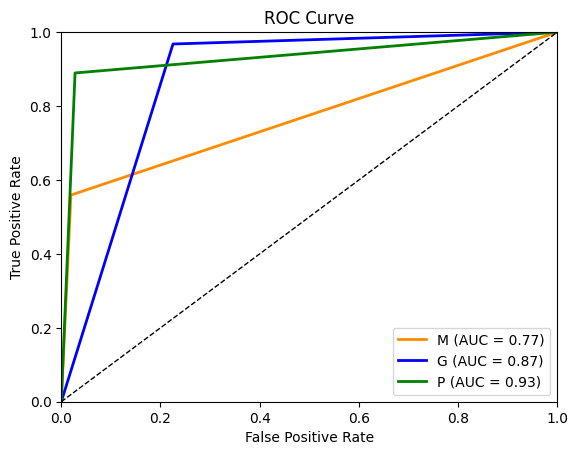

#################### vgg16_base ####################
Confusion Matrix:
[[ 66  71  15]
 [  9 251  20]
 [  1   1 179]]
Classification Report:
              precision    recall  f1-score   support

           M       0.87      0.43      0.58       152
           G       0.78      0.90      0.83       280
           P       0.84      0.99      0.91       181

    accuracy                           0.81       613
   macro avg       0.83      0.77      0.77       613
weighted avg       0.82      0.81      0.79       613



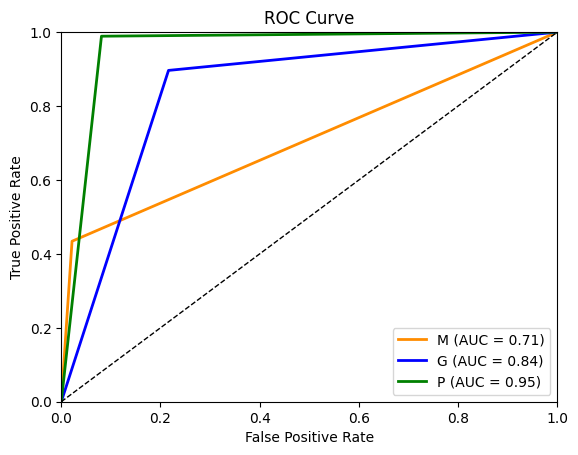

#################### googlenet_base ####################
Confusion Matrix:
[[ 59  92   1]
 [  2 278   0]
 [ 10  27 144]]
Classification Report:
              precision    recall  f1-score   support

           M       0.83      0.39      0.53       152
           G       0.70      0.99      0.82       280
           P       0.99      0.80      0.88       181

    accuracy                           0.78       613
   macro avg       0.84      0.73      0.74       613
weighted avg       0.82      0.78      0.77       613



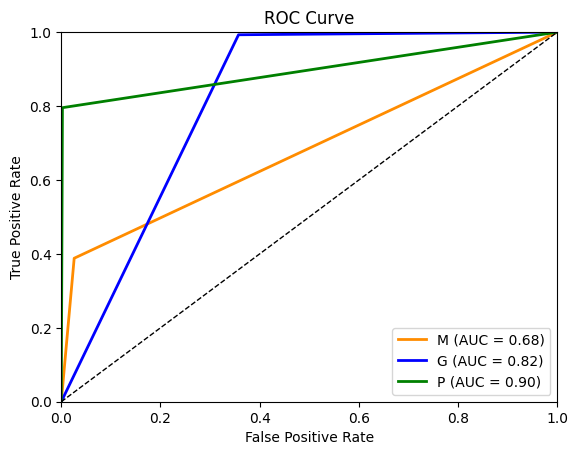

#################### alexnet_base ####################
Confusion Matrix:
[[  3 139  10]
 [  1 269  10]
 [  0  27 154]]
Classification Report:
              precision    recall  f1-score   support

           M       0.75      0.02      0.04       152
           G       0.62      0.96      0.75       280
           P       0.89      0.85      0.87       181

    accuracy                           0.69       613
   macro avg       0.75      0.61      0.55       613
weighted avg       0.73      0.69      0.61       613



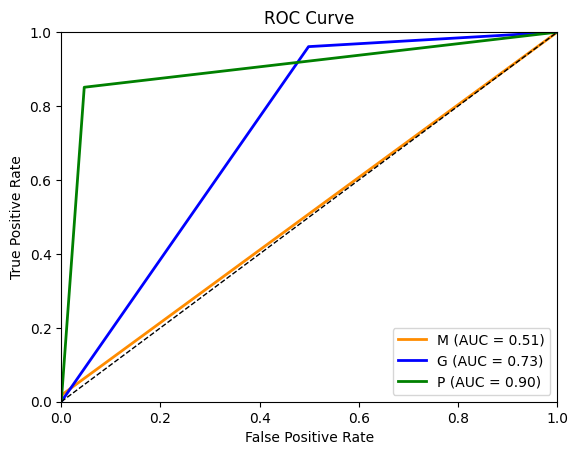

#################### resnet50_pretrained ####################
Confusion Matrix:
[[ 92  60   0]
 [  0 280   0]
 [  7  71 103]]
Classification Report:
              precision    recall  f1-score   support

           M       0.93      0.61      0.73       152
           G       0.68      1.00      0.81       280
           P       1.00      0.57      0.73       181

    accuracy                           0.77       613
   macro avg       0.87      0.72      0.76       613
weighted avg       0.84      0.77      0.77       613



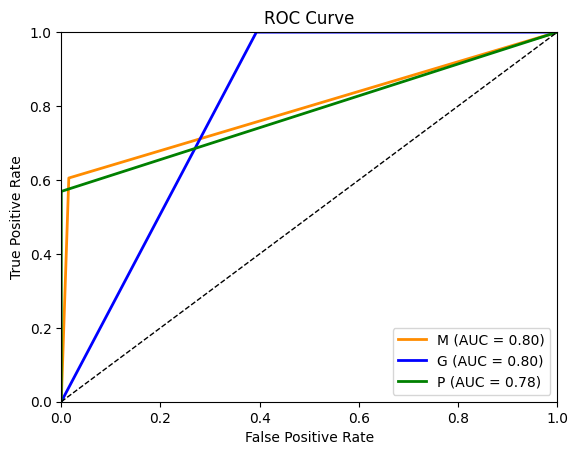

#################### vgg16_pretrained ####################
Confusion Matrix:
[[ 50  89  13]
 [  5 274   1]
 [  2  14 165]]
Classification Report:
              precision    recall  f1-score   support

           M       0.88      0.33      0.48       152
           G       0.73      0.98      0.83       280
           P       0.92      0.91      0.92       181

    accuracy                           0.80       613
   macro avg       0.84      0.74      0.74       613
weighted avg       0.82      0.80      0.77       613



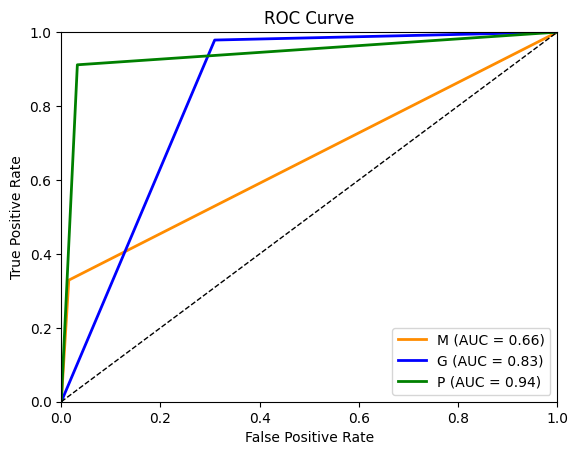

#################### googlenet_pretrained ####################
Confusion Matrix:
[[133  16   3]
 [  1 278   1]
 [ 21  27 133]]
Classification Report:
              precision    recall  f1-score   support

           M       0.86      0.88      0.87       152
           G       0.87      0.99      0.93       280
           P       0.97      0.73      0.84       181

    accuracy                           0.89       613
   macro avg       0.90      0.87      0.88       613
weighted avg       0.89      0.89      0.88       613



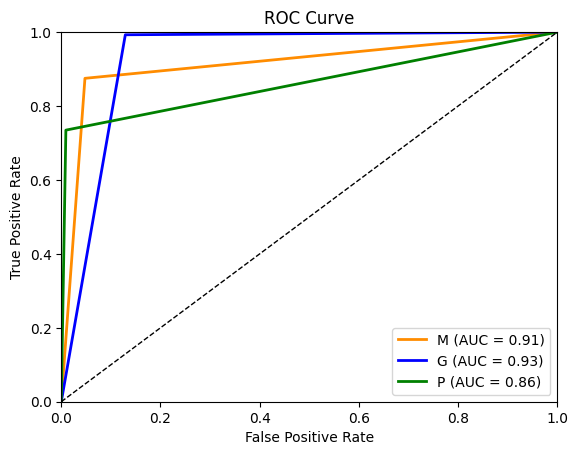

#################### alexnet_pretrained ####################
Confusion Matrix:
[[ 83  59  10]
 [ 53 220   7]
 [  6  18 157]]
Classification Report:
              precision    recall  f1-score   support

           M       0.58      0.55      0.56       152
           G       0.74      0.79      0.76       280
           P       0.90      0.87      0.88       181

    accuracy                           0.75       613
   macro avg       0.74      0.73      0.74       613
weighted avg       0.75      0.75      0.75       613



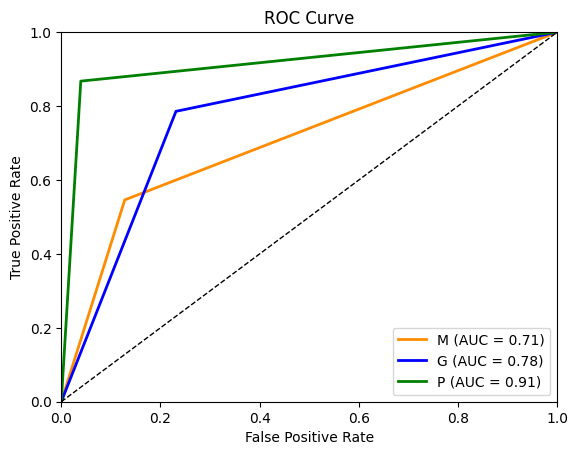

In [ ]:
# Display evaluation metrics for all models
print_report(resnet50_base,"resnet50_base",test_loader)
print_report(vgg16_base,"vgg16_base",test_loader)
print_report(googlenet_base,"googlenet_base",test_loader)
print_report(alexnet_base,"alexnet_base",test_loader)
print_report(resnet50_pretrained,"resnet50_pretrained",test_loader)
print_report(vgg16_pretrained,"vgg16_pretrained",test_loader)
print_report(googlenet_pretrained,"googlenet_pretrained",test_loader)
print_report(alexnet_pretrained,"alexnet_pretrained",test_loader)

# Exploration



#################### resnet50_base ####################
Confusion Matrix:
[[ 87  53  12]
 [  9 271   0]
 [  0  17 164]]
Classification Report:
              precision    recall  f1-score   support

           M       0.91      0.57      0.70       152
           G       0.79      0.97      0.87       280
           P       0.93      0.91      0.92       181

    accuracy                           0.85       613
   macro avg       0.88      0.82      0.83       613
weighted avg       0.86      0.85      0.84       613



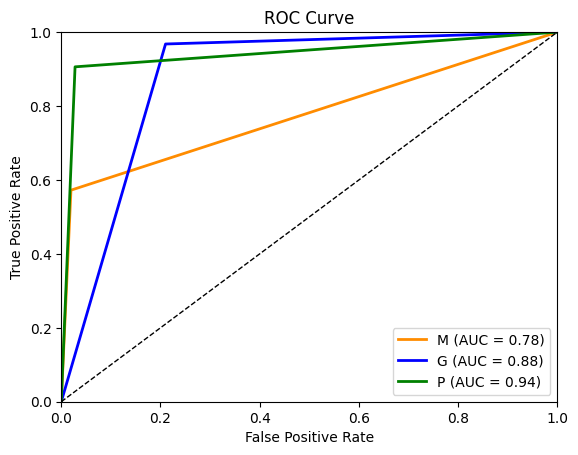

#################### vgg16_base ####################
Confusion Matrix:
[[ 66  71  15]
 [  9 251  20]
 [  1   1 179]]
Classification Report:
              precision    recall  f1-score   support

           M       0.87      0.43      0.58       152
           G       0.78      0.90      0.83       280
           P       0.84      0.99      0.91       181

    accuracy                           0.81       613
   macro avg       0.83      0.77      0.77       613
weighted avg       0.82      0.81      0.79       613



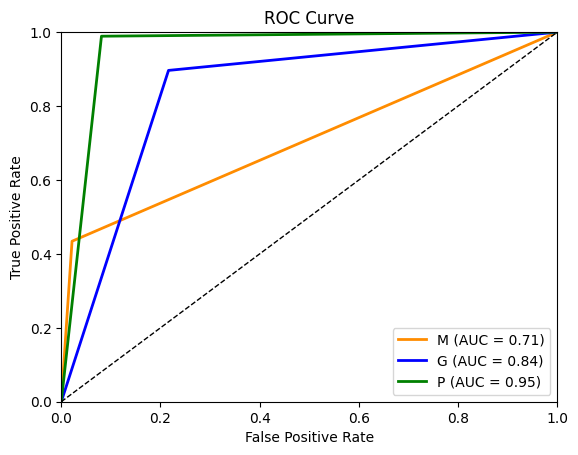

#################### googlenet_base ####################
Confusion Matrix:
[[ 59  92   1]
 [  2 278   0]
 [  7  25 149]]
Classification Report:
              precision    recall  f1-score   support

           M       0.87      0.39      0.54       152
           G       0.70      0.99      0.82       280
           P       0.99      0.82      0.90       181

    accuracy                           0.79       613
   macro avg       0.85      0.73      0.75       613
weighted avg       0.83      0.79      0.78       613



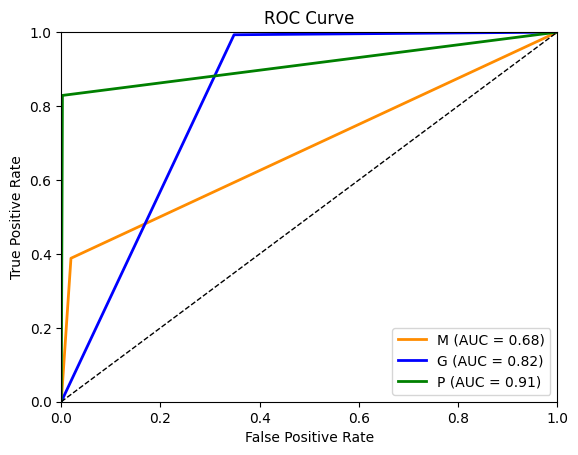

#################### alexnet_base ####################
Confusion Matrix:
[[  3 139  10]
 [  1 269  10]
 [  0  26 155]]
Classification Report:
              precision    recall  f1-score   support

           M       0.75      0.02      0.04       152
           G       0.62      0.96      0.75       280
           P       0.89      0.86      0.87       181

    accuracy                           0.70       613
   macro avg       0.75      0.61      0.55       613
weighted avg       0.73      0.70      0.61       613



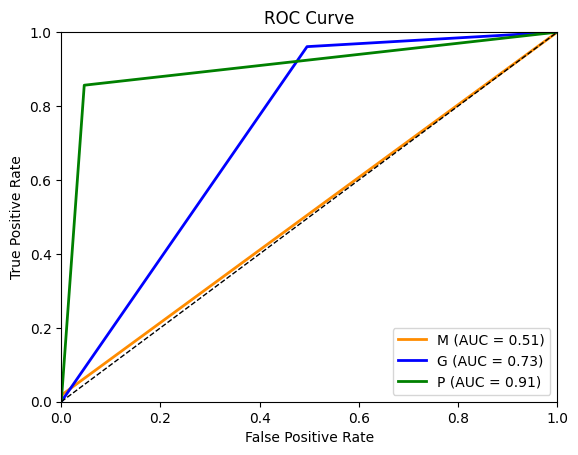

#################### resnet50_pretrained ####################
Confusion Matrix:
[[ 85  67   0]
 [  0 280   0]
 [  5  72 104]]
Classification Report:
              precision    recall  f1-score   support

           M       0.94      0.56      0.70       152
           G       0.67      1.00      0.80       280
           P       1.00      0.57      0.73       181

    accuracy                           0.77       613
   macro avg       0.87      0.71      0.74       613
weighted avg       0.83      0.77      0.76       613



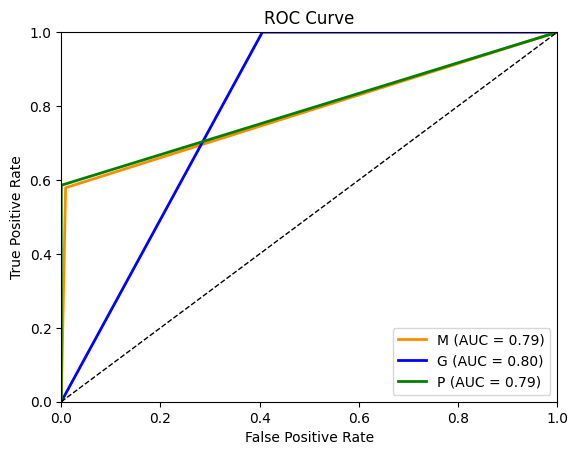

#################### vgg16_pretrained ####################
Confusion Matrix:
[[ 45  94  13]
 [  4 275   1]
 [  2  17 162]]
Classification Report:
              precision    recall  f1-score   support

           M       0.88      0.30      0.44       152
           G       0.71      0.98      0.83       280
           P       0.92      0.90      0.91       181

    accuracy                           0.79       613
   macro avg       0.84      0.72      0.73       613
weighted avg       0.82      0.79      0.76       613



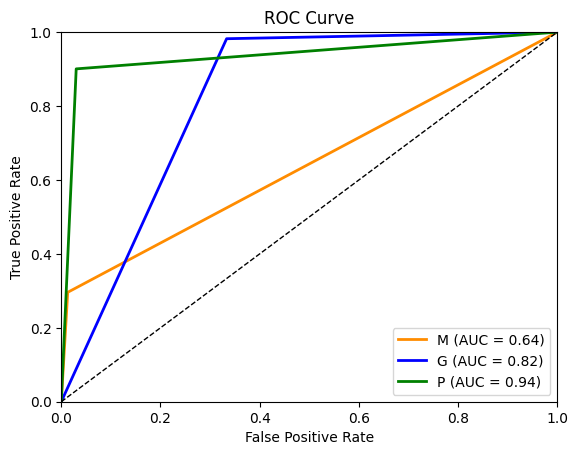

#################### googlenet_pretrained ####################
Confusion Matrix:
[[130  19   3]
 [  1 278   1]
 [ 17  21 143]]
Classification Report:
              precision    recall  f1-score   support

           M       0.88      0.86      0.87       152
           G       0.87      0.99      0.93       280
           P       0.97      0.79      0.87       181

    accuracy                           0.90       613
   macro avg       0.91      0.88      0.89       613
weighted avg       0.90      0.90      0.90       613



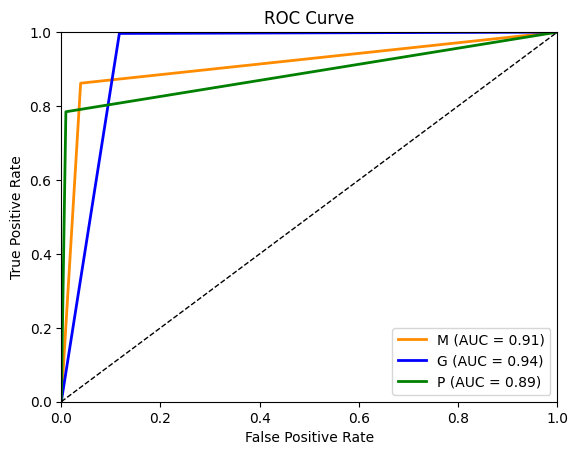

#################### alexnet_pretrained ####################
Confusion Matrix:
[[ 83  58  11]
 [ 54 219   7]
 [  5  15 161]]
Classification Report:
              precision    recall  f1-score   support

           M       0.58      0.55      0.56       152
           G       0.75      0.78      0.77       280
           P       0.90      0.89      0.89       181

    accuracy                           0.76       613
   macro avg       0.74      0.74      0.74       613
weighted avg       0.75      0.76      0.75       613



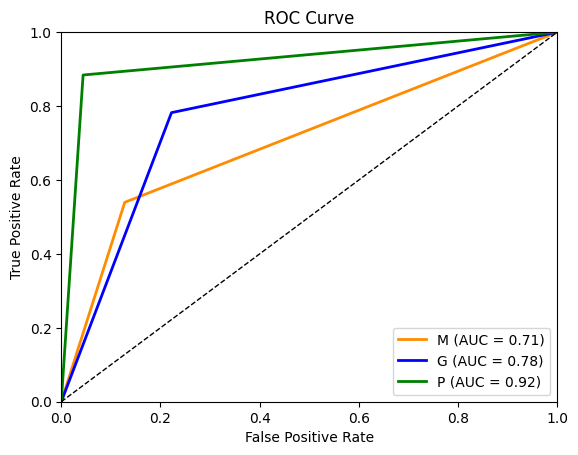

In [ ]:
#### Exploration with adding noise to images ####
print_report(resnet50_base,"resnet50_base",exploration_1_loader)
print_report(vgg16_base,"vgg16_base",exploration_1_loader)
print_report(googlenet_base,"googlenet_base",exploration_1_loader)
print_report(alexnet_base,"alexnet_base",exploration_1_loader)
print_report(resnet50_pretrained,"resnet50_pretrained",exploration_1_loader)
print_report(vgg16_pretrained,"vgg16_pretrained",exploration_1_loader)
print_report(googlenet_pretrained,"googlenet_pretrained",exploration_1_loader)
print_report(alexnet_pretrained,"alexnet_pretrained",exploration_1_loader)

#################### resnet50_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 47  89  16]
 [  6 272   2]
 [  0  22 159]]
Classification Report:
              precision    recall  f1-score   support

           M       0.89      0.31      0.46       152
           G       0.71      0.97      0.82       280
           P       0.90      0.88      0.89       181

    accuracy                           0.78       613
   macro avg       0.83      0.72      0.72       613
weighted avg       0.81      0.78      0.75       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


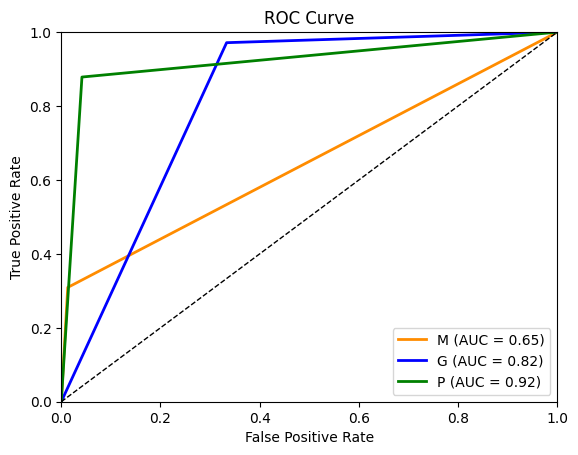

#################### vgg16_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 46  52  54]
 [ 17 186  77]
 [  0   1 180]]
Classification Report:
              precision    recall  f1-score   support

           M       0.73      0.30      0.43       152
           G       0.78      0.66      0.72       280
           P       0.58      0.99      0.73       181

    accuracy                           0.67       613
   macro avg       0.70      0.65      0.63       613
weighted avg       0.71      0.67      0.65       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


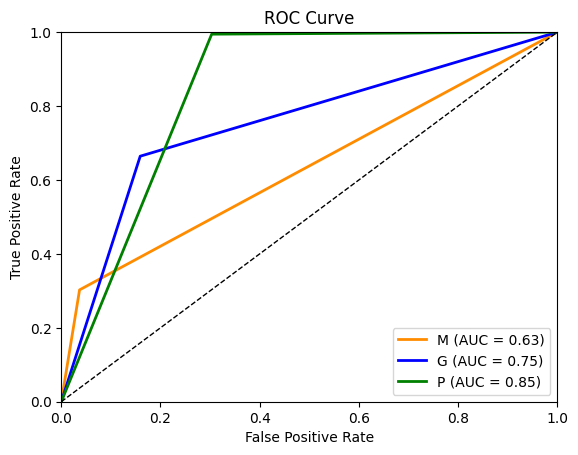

#################### googlenet_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 39 101  12]
 [  1 276   3]
 [  0  15 166]]
Classification Report:
              precision    recall  f1-score   support

           M       0.97      0.26      0.41       152
           G       0.70      0.99      0.82       280
           P       0.92      0.92      0.92       181

    accuracy                           0.78       613
   macro avg       0.87      0.72      0.71       613
weighted avg       0.83      0.78      0.75       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


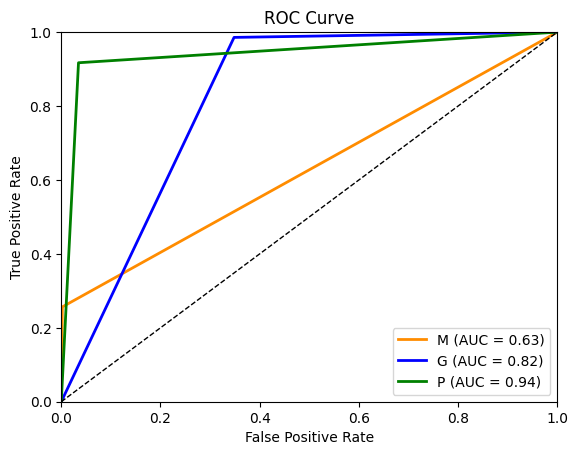

#################### alexnet_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[  4 122  26]
 [  1 239  40]
 [  0   6 175]]
Classification Report:
              precision    recall  f1-score   support

           M       0.80      0.03      0.05       152
           G       0.65      0.85      0.74       280
           P       0.73      0.97      0.83       181

    accuracy                           0.68       613
   macro avg       0.73      0.62      0.54       613
weighted avg       0.71      0.68      0.59       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


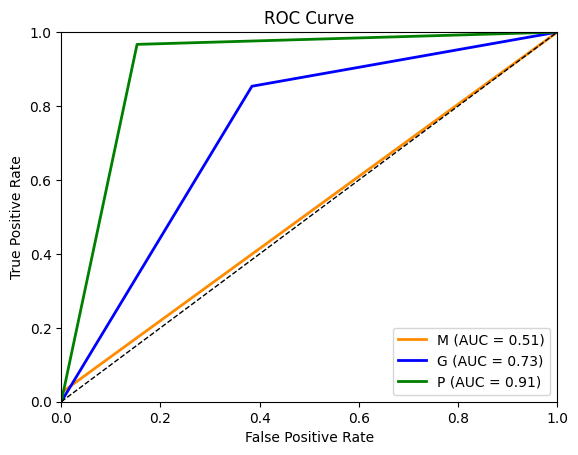

#################### resnet50_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 69  82   1]
 [  0 280   0]
 [  4  42 135]]
Classification Report:
              precision    recall  f1-score   support

           M       0.95      0.45      0.61       152
           G       0.69      1.00      0.82       280
           P       0.99      0.75      0.85       181

    accuracy                           0.79       613
   macro avg       0.88      0.73      0.76       613
weighted avg       0.84      0.79      0.78       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


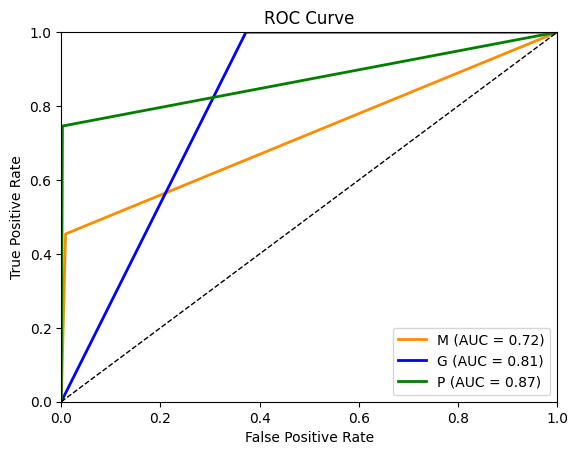

#################### vgg16_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 24  97  31]
 [  0 267  13]
 [  0   9 172]]
Classification Report:
              precision    recall  f1-score   support

           M       1.00      0.16      0.27       152
           G       0.72      0.95      0.82       280
           P       0.80      0.95      0.87       181

    accuracy                           0.76       613
   macro avg       0.84      0.69      0.65       613
weighted avg       0.81      0.76      0.70       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


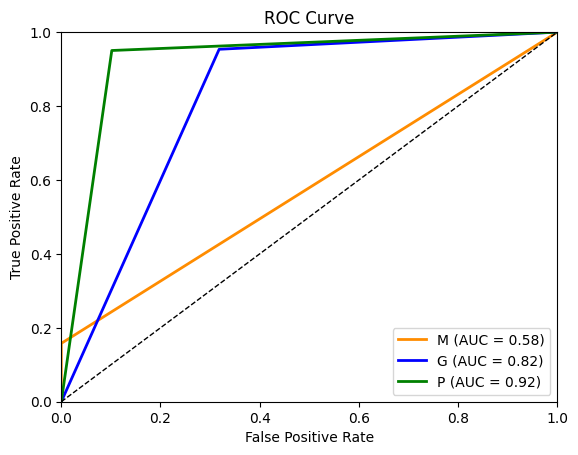

#################### googlenet_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[129  19   4]
 [  2 277   1]
 [ 14  40 127]]
Classification Report:
              precision    recall  f1-score   support

           M       0.89      0.85      0.87       152
           G       0.82      0.99      0.90       280
           P       0.96      0.70      0.81       181

    accuracy                           0.87       613
   macro avg       0.89      0.85      0.86       613
weighted avg       0.88      0.87      0.87       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


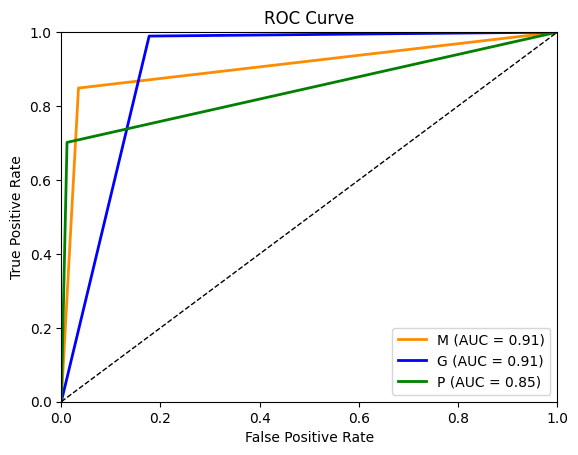

#################### alexnet_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 69  57  26]
 [ 59 190  31]
 [  3   4 174]]
Classification Report:
              precision    recall  f1-score   support

           M       0.53      0.45      0.49       152
           G       0.76      0.68      0.72       280
           P       0.75      0.96      0.84       181

    accuracy                           0.71       613
   macro avg       0.68      0.70      0.68       613
weighted avg       0.70      0.71      0.70       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


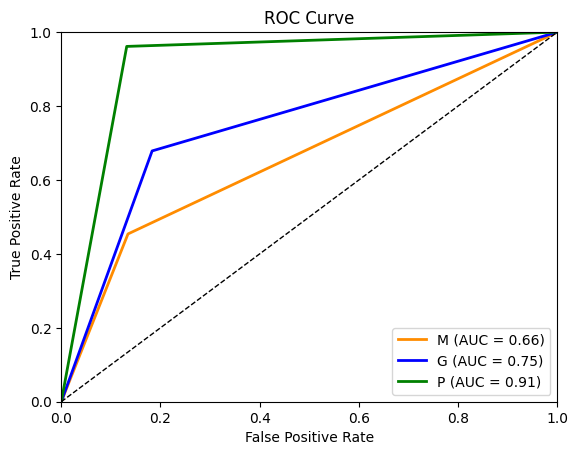

In [ ]:
#### Exploration with stretching images ####
print_report(resnet50_base,"resnet50_base",exploration_2_loader)
print_report(vgg16_base,"vgg16_base",exploration_2_loader)
print_report(googlenet_base,"googlenet_base",exploration_2_loader)
print_report(alexnet_base,"alexnet_base",exploration_2_loader)
print_report(resnet50_pretrained,"resnet50_pretrained",exploration_2_loader)
print_report(vgg16_pretrained,"vgg16_pretrained",exploration_2_loader)
print_report(googlenet_pretrained,"googlenet_pretrained",exploration_2_loader)
print_report(alexnet_pretrained,"alexnet_pretrained",exploration_2_loader)

#################### resnet50_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 50  87  15]
 [  6 274   0]
 [  0  17 164]]
Classification Report:
              precision    recall  f1-score   support

           M       0.89      0.33      0.48       152
           G       0.72      0.98      0.83       280
           P       0.92      0.91      0.91       181

    accuracy                           0.80       613
   macro avg       0.84      0.74      0.74       613
weighted avg       0.82      0.80      0.77       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


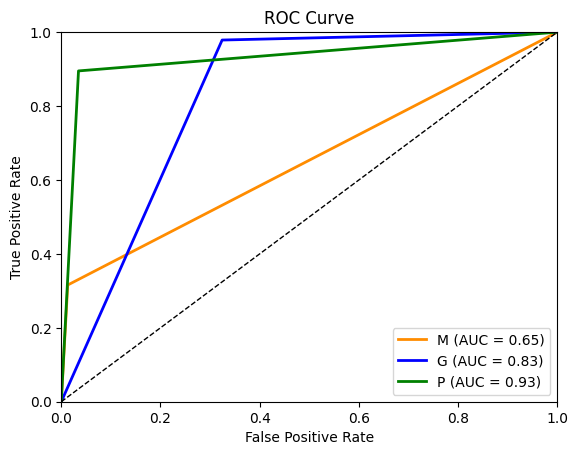

#################### vgg16_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 45  53  54]
 [ 17 186  77]
 [  0   1 180]]
Classification Report:
              precision    recall  f1-score   support

           M       0.73      0.30      0.42       152
           G       0.78      0.66      0.72       280
           P       0.58      0.99      0.73       181

    accuracy                           0.67       613
   macro avg       0.69      0.65      0.62       613
weighted avg       0.70      0.67      0.65       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


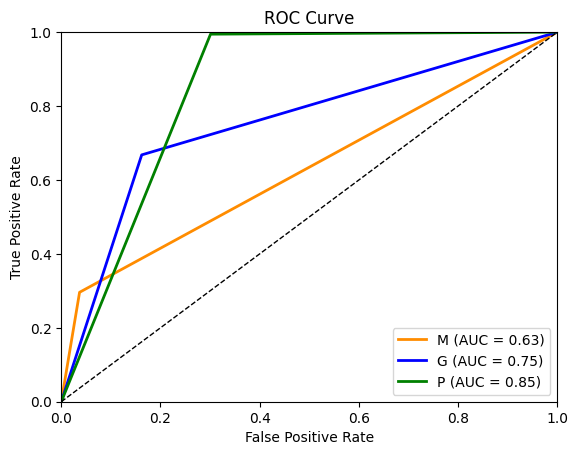

#################### googlenet_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 40 100  12]
 [  0 276   4]
 [  0  13 168]]
Classification Report:
              precision    recall  f1-score   support

           M       1.00      0.26      0.42       152
           G       0.71      0.99      0.83       280
           P       0.91      0.93      0.92       181

    accuracy                           0.79       613
   macro avg       0.87      0.73      0.72       613
weighted avg       0.84      0.79      0.75       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


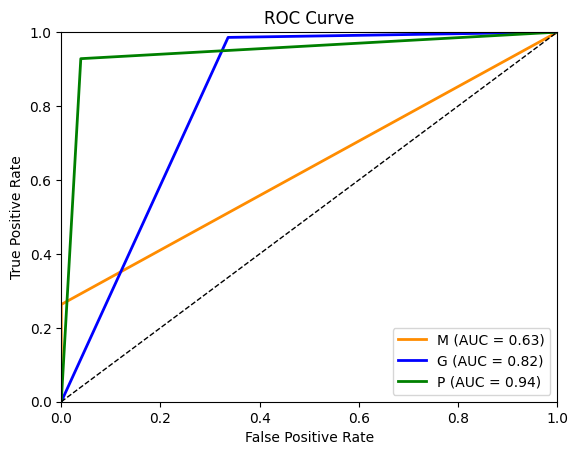

#################### alexnet_base ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[  4 121  27]
 [  1 239  40]
 [  0   7 174]]
Classification Report:
              precision    recall  f1-score   support

           M       0.80      0.03      0.05       152
           G       0.65      0.85      0.74       280
           P       0.72      0.96      0.82       181

    accuracy                           0.68       613
   macro avg       0.72      0.61      0.54       613
weighted avg       0.71      0.68      0.59       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


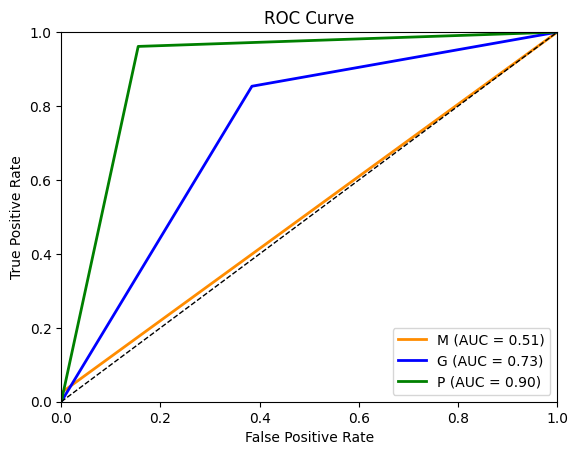

#################### resnet50_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 63  88   1]
 [  0 280   0]
 [  4  49 128]]
Classification Report:
              precision    recall  f1-score   support

           M       0.94      0.41      0.58       152
           G       0.67      1.00      0.80       280
           P       0.99      0.71      0.83       181

    accuracy                           0.77       613
   macro avg       0.87      0.71      0.73       613
weighted avg       0.83      0.77      0.75       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


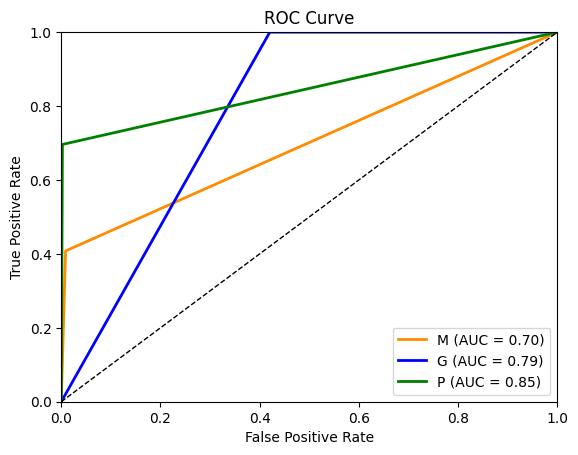

#################### vgg16_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 22 100  30]
 [  0 267  13]
 [  0  11 170]]
Classification Report:
              precision    recall  f1-score   support

           M       1.00      0.14      0.25       152
           G       0.71      0.95      0.81       280
           P       0.80      0.94      0.86       181

    accuracy                           0.75       613
   macro avg       0.83      0.68      0.64       613
weighted avg       0.81      0.75      0.69       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


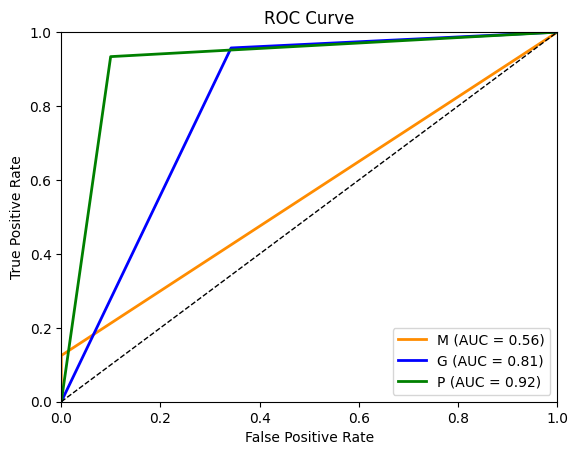

#################### googlenet_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[126  22   4]
 [  1 278   1]
 [ 12  30 139]]
Classification Report:
              precision    recall  f1-score   support

           M       0.91      0.83      0.87       152
           G       0.84      0.99      0.91       280
           P       0.97      0.77      0.86       181

    accuracy                           0.89       613
   macro avg       0.90      0.86      0.88       613
weighted avg       0.89      0.89      0.88       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


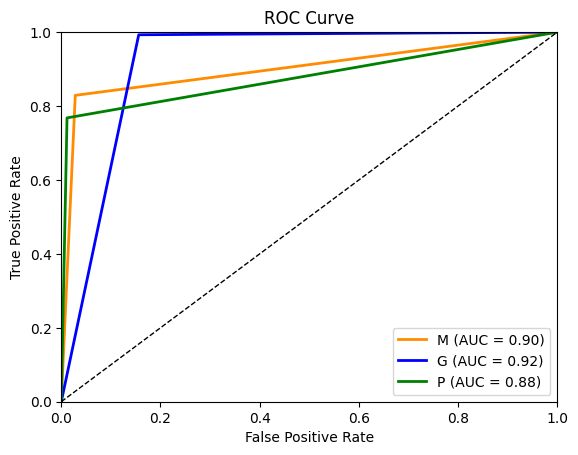

#################### alexnet_pretrained ####################


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix:
[[ 65  57  30]
 [ 57 190  33]
 [  2   4 175]]
Classification Report:
              precision    recall  f1-score   support

           M       0.52      0.43      0.47       152
           G       0.76      0.68      0.72       280
           P       0.74      0.97      0.84       181

    accuracy                           0.70       613
   macro avg       0.67      0.69      0.67       613
weighted avg       0.69      0.70      0.69       613



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


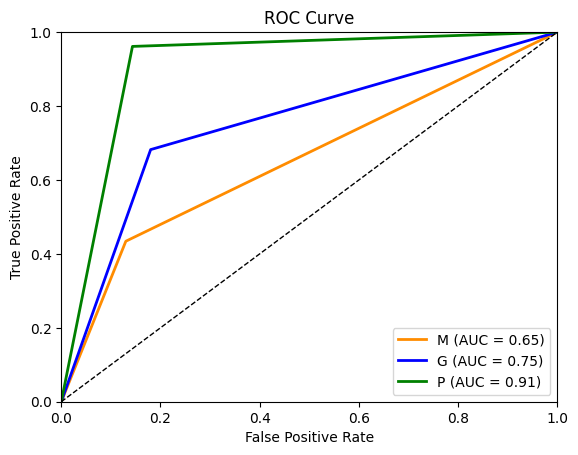

In [ ]:
#### Exploration with adding noise and stretching images ####
print_report(resnet50_base,"resnet50_base",exploration_3_loader)
print_report(vgg16_base,"vgg16_base",exploration_3_loader)
print_report(googlenet_base,"googlenet_base",exploration_3_loader)
print_report(alexnet_base,"alexnet_base",exploration_3_loader)
print_report(resnet50_pretrained,"resnet50_pretrained",exploration_3_loader)
print_report(vgg16_pretrained,"vgg16_pretrained",exploration_3_loader)
print_report(googlenet_pretrained,"googlenet_pretrained",exploration_3_loader)
print_report(alexnet_pretrained,"alexnet_pretrained",exploration_3_loader)